# Logistic Regression

This notebook explores the logistic regression classification algorithm. 

In [1]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize

In [2]:
iris = fetch_ucirepo(id=53) 
iris.variables

,name,role,type,demographic,description,units,missing_values
0,sepal length,Feature,Continuous,None,None,cm,no
1,sepal width,Feature,Continuous,None,None,cm,no
2,petal length,Feature,Continuous,None,None,cm,no
3,petal width,Feature,Continuous,None,None,cm,no
4,class,Target,Categorical,None,"class of iris plant: Iris Setosa, Iris Versico...",None,no


In [3]:
m = 150  # Number of points to use

petal_length = iris.data.features["petal length"][:m]
petal_width = iris.data.features["petal width"][:m]

X = np.stack((np.ones(m), petal_length, petal_width)).T
y = pd.Categorical(iris.data.targets["class"]).codes

# Keep just two classes for simplicity
keep_idx = np.argwhere(y != 0).flatten()
X = X[keep_idx]
y = y[keep_idx]
y = y - 1  # Relabel classes

In linear regression the hypothesis function $h_\theta(x)$ is equal to $\theta^T x$. In logistic regression we do one extra step and input that dot product into the function $g(z)$:
$$
g(z) = \frac{1}{1 + \exp(-z)}
$$

This maps the values to the range $[0, 1]$ smoothly.

So,
$$
h_\theta(x) = \frac{1}{1 + \exp(-\theta^T x)}
$$

Let's consider a binary classification model, i.e. only two classes are possible, 0 and 1. Ideally, our function $h_\theta(x)$ would be a good estimate of probability. In other words:
$$
\begin{align*}
P(y = 1 \vert x; \theta) &= h_\theta(x)\\
P(y = 0 \vert x; \theta) &= 1 - h_\theta(x)
\end{align*}
$$

Read the above as "probability of y being equal to 1 (or 0), given x and parameterized by theta".

The exact same can be compactly written as:
$$
p(y \vert x; \theta) = (h(x))^y (1 - h(x))^{1 - y}
$$

Next, we introduce the **likelihood of parameters** which is a function $L(\theta)$. It is effectively equal to the probability density of the data $p(y \vert X; \theta)$, but we simply look at it from a different perspective. 

When we're concerned with the probability of data, we're free to change the data, but the parameters stay fixed. When we talk about the likelihood of parameters, the parameters can change, but the (training) data itself remains fixed. Likelihood is explicitly a function of parameters, even though, technically, probability also depends on them. 

This change of perspective allows us to look for the best set of parameters for the data we observed. "The best" meaning the one that maximizes the chance of observing that data, or the likelihood function itself. This is known as **maximum likelihood principle**.

We make one important assumption in this model: data is independently and identically distributed (i.i.d.). This allows us to calculate the likelihood as follows:
$$
\begin{align*}
L(\theta) &= p(y \vert X; \theta)\\
&= \prod_{i = 1}^{m} p(y^{(i)} \vert x^{(i)}; \theta)\\
&= \prod_{i = 1}^{m} (h(x^{(i)}))^{y^{(i)}} (1 - h(x^{(i)}))^{1 - y^{(i)}}
\end{align*}
$$

Reminder: $h(x)$ depends on $\theta$ but it is omitted for improved tidiness.

We can apply any strictly monotonic function to likelihood and find its maxima instead. For computational easiness, we often consider log-likelihood $\ell(\theta)$, which is equal to $\log \left(L(\theta)\right)$.
$$
\ell (\theta) = \sum_{i = 1}^m y^{(i)} \log h(x^{(i)}) + (1 - y^{(i)}) \log (1 - h(x^{(i)}))
$$

Since we want to maximize this function, we will consider its gradient. We can substitute the sigmoid function for $h$ and get that each partial derivative is then:
$$
\frac{\partial}{\partial \theta_j}\ell(\theta) = (y - h(x))x_j \quad (\text{for every }j = 0, \dots, n)
$$

Finally, the update rule for the gradient ascent in logistic regression:
$$
\theta_j := \theta_j + \alpha \sum_{i = 1}^{m} (y^{(i)} - h_\theta(x^{(i)}) ) x^{(i)}_j \quad (\text{for every }j = 0, \dots, n)
$$

The format of the derivative is exactly the same as in linear regression, which is actually the case for all generalized linear models (GLMs). What's different, though, is the hypothesis function $h_\theta(x)$ that is now equal to $g(\theta^T x)$ rather than $\theta^T x$.


In [4]:
def sigmoid(z):
	return 1 / (1 + np.exp(-z))


def negative_log_likelihood(theta, X, y):
	# Compact notation
	e = 0.000001
	h = sigmoid(X @ theta)
	# We return negative log likelihood since we're minimizing with SciPy
	return (-np.dot(y, np.log(h + e)) - np.dot(1 - y, np.log(1 - h + e)))


def gradient(theta, X, y):
	residuals = sigmoid(X @ theta) - y
	return X.T @ residuals / len(y)

In [5]:
initial_guess = np.zeros(X.shape[1])
res = scipy.optimize.minimize(fun=negative_log_likelihood, x0=initial_guess, args=(X, y), jac=gradient, method='BFGS')
theta = res.x

print(theta)

[-45.279744     5.75562411  10.44790851]


In [6]:
probabilities = sigmoid(X @ theta)
predictions = np.where(probabilities >= 0.5, 1, 0)

n_correct = np.count_nonzero(predictions == y)
accuracy = n_correct / len(y)

print(accuracy)

0.94


To visualize the decision boundary, we will solve $h(\theta^T X) = 0.5$. We get $\theta^T X = 0$, or, with two features:
$$
\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0
$$

We can solve for $x_2$:
$$
x_2 = -\frac{\theta_0 + \theta_1 x_1}{\theta_2}
$$

In [7]:
def y_val(x, theta):
	return -(theta[0] + theta[1] * x) / theta[2]

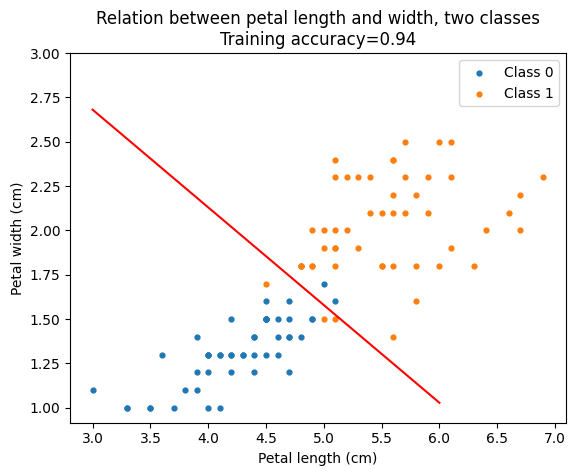

Note that some points are occluded.


In [8]:
x_vals = np.arange(np.min(X[:, 1]), np.max(X[:, 1]))
y_vals = y_val(x_vals, theta)

for lbl in np.unique(y):
	plt.scatter(X[y == lbl, 1], X[y == lbl, 2], label=f'Class {lbl}', s=12)

plt.plot(x_vals, y_vals, 'r')

plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.title(f"Relation between petal length and width, two classes\nTraining accuracy={accuracy}")

plt.ylim(None, 3)
plt.legend()
plt.show()

print("Note that some points are occluded.")